# Hypothesis testing

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
try:
    import statadict
except ImportError:
    !pip install statadict

<IPython.core.display.Javascript object>

In [4]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## Classical hypothesis testing

Exploring the data from the NSFG, we saw several "apparent effects," including differences between first babies and others.
So far we have taken these effects at face value; in this chapter, we put them to the test.

The fundamental question we want to address is whether the effects we see in a sample are likely to appear in the larger population.
For example, in the NSFG sample we see a difference in mean pregnancy length for first babies and others.
We would like to know if that effect reflects a real difference for women in the U.S., or if it might appear in the sample by chance.

There are several ways we could formulate this question, including Fisher null hypothesis testing, Neyman-Pearson decision theory, and Bayesian inference.
What I present here is a subset of all three that makes up most of what people use in practice, which I will call **classical hypothesis testing**.

The goal of classical hypothesis testing is to answer the question, "Given a sample and an apparent effect, what is the probability of seeing such an effect by chance?" Here's how we answer that question:

-   The first step is to quantify the size of the apparent effect by choosing a **test statistic**.
In the NSFG example, the apparent effect is a difference in pregnancy length between first babies and others, so a natural choice for the test statistic is the difference in means between the two groups.

-   The second step is to define a **null hypothesis**, which is a model of the system based on the assumption that the apparent effect is not real.
In the NSFG example the null hypothesis is that there is no difference between first babies and others; that is, that pregnancy lengths for both groups have the same distribution.

-   The third step is to compute a **p-value**, which is the probability of seeing the apparent effect if the null hypothesis is true.
In the NSFG example, we would compute the actual difference in means, then compute the probability of seeing a difference as big, or bigger, under the null hypothesis.

-   The last step is to interpret the result.
If the p-value is low, the effect is said to be **statistically significant**, which means that it is unlikely to have occurred by chance.
In that case we infer that the effect is more likely to appear in the larger population.

The logic of this process is similar to a proof by contradiction.
To prove a mathematical statement, A, you assume temporarily that A is false.
If that assumption leads to a contradiction, you conclude that A must actually be true.

Similarly, to test a hypothesis like, "This effect is real," we assume, temporarily, that it is not.
That's the null hypothesis.
Based on that assumption, we compute the probability of the apparent effect.
That's the p-value.
If the p-value is low, we conclude that the null hypothesis is unlikely to be true.

## `HypothesisTest`

`HypothesisTest` is a class that represents the structure of a classical hypothesis test.
Here is the definition:

In [4]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.make_model()
        self.actual = self.test_statistic(data)

    def p_value(self, iters=1000):
        self.test_stats = [self.test_statistic(self.run_model()) for _ in range(iters)]
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def test_statistic(self, data):
        raise NotImplementedError()

    def make_model(self):
        pass

    def run_model(self):
        raise NotImplementedError()

<IPython.core.display.Javascript object>

`HypothesisTest` is an abstract parent class that provides complete definitions for some methods and place-keepers for others.
Child classes based on `HypothesisTest` inherit `__init__` and `p_value` and provide `test_statistic`, `run_model`, and optionally `make_model`.

`__init__` takes the data in whatever form is appropriate.
It calls `make_model`, which builds a representation of the null hypothesis, then passes the data to `test_statistic`, which computes the size of the effect in the sample.

`p_value` computes the probability of the apparent effect under the null hypothesis.
It takes as a parameter `iters`, which is the number of simulations to run.
The first line generates simulated data, computes test statistics, and stores them in `test_stats`.
The result is the fraction of elements in `test_stats` that exceed or equal the observed test statistic, `self.actual`.

As a simple example, suppose we toss a coin 250 times and see 140 heads and 110 tails.
Based on this result, we might suspect that the coin is biased; that is, more likely to land heads.
To test this hypothesis, we compute the probability of seeing such a difference if the coin is actually fair:

In [112]:
n = 250
p = 0.5


def excess_heads(heads):
    expected = n * p
    return heads - expected

<IPython.core.display.Javascript object>

In [113]:
heads = 140
tails = 110

observed_stat = excess_heads(heads)
observed_stat

15.0

<IPython.core.display.Javascript object>

In [114]:
def simulate_flips():
    flips = np.random.choice(["H", "T"], p=[p, 1 - p], size=n)
    heads = np.sum(flips == "H")
    return heads

<IPython.core.display.Javascript object>

In [115]:
simulate_flips()

115

<IPython.core.display.Javascript object>

In [116]:
simulated_stats = [excess_heads(simulate_flips()) for i in range(10001)]

<IPython.core.display.Javascript object>

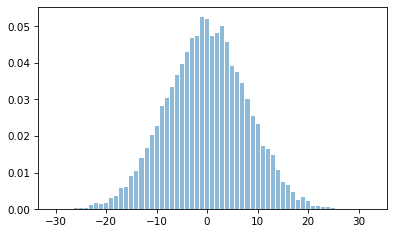

<IPython.core.display.Javascript object>

In [117]:
from empiricaldist import Pmf

pmf_effects = Pmf.from_seq(simulated_stats)
pmf_effects.bar(alpha=0.5)

In [118]:
def compute_p_value(simulated, observed):
    return (np.asarray(simulated) >= observed).mean()

<IPython.core.display.Javascript object>

In [119]:
compute_p_value(simulated_stats, observed_stat)

0.030796920307969204

<IPython.core.display.Javascript object>

In [120]:
def diff_heads(heads):
    expected = n * p
    return abs(heads - expected)

<IPython.core.display.Javascript object>

In [121]:
observed_diff = diff_heads(140)
observed_diff

15.0

<IPython.core.display.Javascript object>

In [122]:
simulated_diffs = [diff_heads(simulate_flips()) for i in range(10001)]

<IPython.core.display.Javascript object>

In [123]:
compute_p_value(simulated_diffs, observed_diff)

0.066993300669933

<IPython.core.display.Javascript object>

In [124]:
from scipy.stats import binom

ks = np.arange(n + 1)
ps = binom.pmf(ks, n, p)

<IPython.core.display.Javascript object>

In [125]:
expected = n * p
pmf_binom = Pmf(ps, ks - expected)

<IPython.core.display.Javascript object>

In [162]:
from thinkstats import underride


def fill_tail(pmf, observed, side, **options):
    """Fill the area under a PMF, right or left of an observed value."""
    options = underride(options, alpha=0.3)

    if side == "right":
        condition = pmf.qs >= observed
    elif side == "left":
        condition = pmf.qs <= observed

    series = pmf[condition]
    plt.fill_between(series.index, 0, series, **options)

<IPython.core.display.Javascript object>

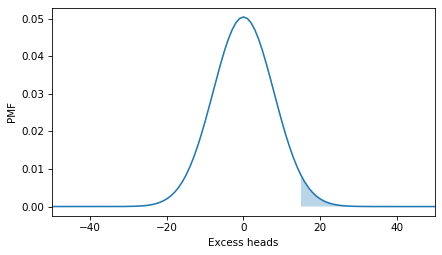

<IPython.core.display.Javascript object>

In [163]:
fill_tail(pmf_binom, observed_stat, "right")

pmf_binom.plot()
decorate(xlabel="Excess heads", xlim=[-50, 50], ylabel="PMF")

In [164]:
pmf_binom.ge_dist(observed_stat)

0.03321057562002166

<IPython.core.display.Javascript object>

In [165]:
pmf_binom.le_dist(-observed_stat)

0.033210575620021665

<IPython.core.display.Javascript object>

The result is about 0.07, which means that if the coin is fair, we expect to see a difference as big as 30 about 7% of the time.

How should we interpret this result? By convention, 5% is the threshold of statistical significance.
If the p-value is less than 5%, the effect is considered significant; otherwise it is not.

But the choice of 5% is arbitrary, and (as we will see later) the p-value depends on the choice of the test statistics and the model of the null hypothesis.
So p-values should not be considered precise measurements.

I recommend interpreting p-values according to their order of magnitude: if the p-value is less than 1%, the effect is unlikely to be due to chance; if it is greater than 10%, the effect can plausibly be explained by chance.
P-values between 1% and 10% should be considered borderline.
So in this example I conclude that the data do not provide strong evidence that the coin is biased or not.

## Testing a difference in means

One of the most common effects to test is a difference in mean between two groups.
In the NSFG data, we saw that the mean pregnancy length for first babies is slightly longer, and the mean birth weight is slightly smaller.
Now we will see if those effects are statistically significant.

For these examples, the null hypothesis is that the distributions for the two groups are the same.
One way to model the null hypothesis is by **permutation**; that is, we can take values for first babies and others and shuffle them, treating the two groups as one big group:

`data` is a pair of sequences, one for each group.
The test statistic is the absolute difference in the means.

`make_model` records the sizes of the groups, `n` and `m`, and combines the groups into one NumPy array, `self.pool`.

`run_model` simulates the null hypothesis by shuffling the pooled values and splitting them into two groups with sizes `n` and `m`.
As always, the return value from `run_model` has the same format as the observed data.

To test the difference in pregnancy length, we run:

In [166]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

<IPython.core.display.Javascript object>

In [167]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

<IPython.core.display.Javascript object>

In [168]:
data = firsts.prglngth.values, others.prglngth.values

<IPython.core.display.Javascript object>

In [169]:
def diff_means(data):
    group1, group2 = data
    diff = np.mean(group1) - np.mean(group2)
    return np.abs(diff)

<IPython.core.display.Javascript object>

In [170]:
observed_diff = diff_means(data)
observed_diff

0.07803726677754952

<IPython.core.display.Javascript object>

In [171]:
pool = np.hstack(data)
len(pool)

9148

<IPython.core.display.Javascript object>

In [172]:
def simulate_groups(data):
    group1, group2 = data
    n, m = len(group1), len(group2)

    np.random.shuffle(pool)
    return pool[:n], pool[n:]

<IPython.core.display.Javascript object>

In [173]:
diff_means(simulate_groups(data))

0.11634436127683756

<IPython.core.display.Javascript object>

In [174]:
simulated_diffs = [diff_means(simulate_groups(data)) for i in range(1001)]

<IPython.core.display.Javascript object>

In [175]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf


def make_pmf(sample, low, high):
    kde = gaussian_kde(sample)
    qs = np.linspace(low, high, 201)
    ps = kde(qs)
    return Pmf(ps, qs)

<IPython.core.display.Javascript object>

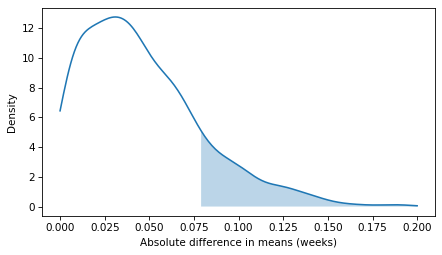

<IPython.core.display.Javascript object>

In [178]:
pmf = make_pmf(simulated_diffs, 0, 0.2)
pmf.plot()
fill_tail(pmf, observed_diff, "right")
decorate(xlabel="Absolute difference in means (weeks)", ylabel="Density")

In [179]:
compute_p_value(simulated_diffs, observed_diff)

0.15584415584415584

<IPython.core.display.Javascript object>

`MakeFrames` reads the NSFG data and returns `DataFrame`s representing all live births, first babies, and others.
We extract pregnancy lengths as NumPy arrays, pass them as data to `DiffMeansPermute`, and compute the p-value.
The result is about 0.17, which means that we expect to see a difference as big as the observed effect about 17% of the time.
So this effect is not statistically significant.

The CDF intersects the observed difference at 0.83, which is the complement of the p-value, 0.17.

If we run the same analysis with birth weight, the computed p-value is 0 -- that is, after 1000 attempts, the simulation never yields an effect as big as the observed difference, 0.12 lbs.
So we would report $p < 0.001$, and conclude that the difference in birth weight is statistically significant.

## Other Test Statistics

We can use the same framework to test for a difference in standard deviation.
In Section [\[visualization\]](#visualization){reference-type="ref" reference="visualization"}, we saw some evidence that first babies are more likely to be early or late, and less likely to be on time.
So we might hypothesize that the standard deviation is higher.
Here's how we can test that:

In [204]:
def diff_stds(data):
    group1, group2 = data
    diff = np.std(group1) - np.std(group2)
    return np.abs(diff)

<IPython.core.display.Javascript object>

In [205]:
observed_diff = diff_stds(data)
observed_diff

0.17600895913991677

<IPython.core.display.Javascript object>

In [206]:
simulated_diffs = [diff_stds(simulate_groups(data)) for i in range(1001)]

<IPython.core.display.Javascript object>

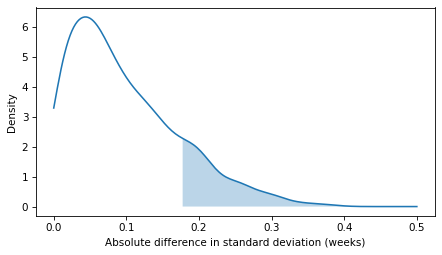

<IPython.core.display.Javascript object>

In [207]:
pmf = make_pmf(simulated_diffs, 0, 0.5)
pmf.plot()
fill_tail(pmf, observed_diff, "right")
decorate(xlabel="Absolute difference in standard deviation (weeks)", ylabel="Density")

In [208]:
compute_p_value(simulated_diffs, observed_diff)

0.16083916083916083

<IPython.core.display.Javascript object>

This is a one-sided test because the hypothesis is that the standard deviation for first babies is higher, not just different.
The p-value is 0.09, which is not statistically significant.

## Testing a correlation

This framework can also test correlations.
For example, in the NSFG data set, the correlation between birth weight and mother's age is about 0.07. It seems like older mothers have heavier babies.
But could this effect be due to chance?

For the test statistic, I use Pearson's correlation, but Spearman's would work as well.
If we had reason to expect positive correlation, we would do a one-sided test.
But since we have no such reason, I'll do a two-sided test using the absolute value of correlation.

The null hypothesis is that there is no correlation between mother's age and birth weight.
By shuffling the observed values, we can simulate a world where the distributions of age and birth weight are the same, but where the variables are unrelated:

In [228]:
subset = live.dropna(subset=["agepreg", "birthwgt_lb", "birthwgt_oz"])
subset.shape

(9038, 244)

<IPython.core.display.Javascript object>

In [229]:
xs = subset["agepreg"]

<IPython.core.display.Javascript object>

In [230]:
ys = subset["birthwgt_lb"] + subset["birthwgt_oz"] / 16

<IPython.core.display.Javascript object>

In [242]:
def correlation(data):
    xs, ys = data
    corr = np.corrcoef(xs, ys)[0, 1]
    return np.abs(corr)

<IPython.core.display.Javascript object>

In [243]:
data = xs, ys
observed_corr = correlation(data)
observed_corr

0.0688339703541091

<IPython.core.display.Javascript object>

In [244]:
def permute(data):
    xs, ys = data
    new_xs = xs.values.copy()
    np.random.shuffle(new_xs)
    return new_xs, ys

<IPython.core.display.Javascript object>

In [245]:
correlation(permute(data))

0.01030229785596149

<IPython.core.display.Javascript object>

In [246]:
simulated_corrs = [correlation(permute(data)) for i in range(1001)]

<IPython.core.display.Javascript object>

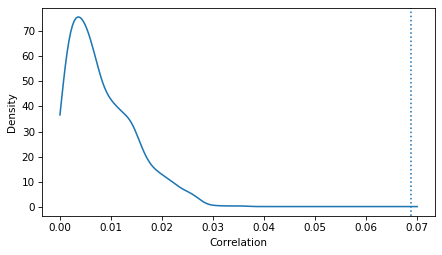

<IPython.core.display.Javascript object>

In [250]:
pmf = make_pmf(simulated_corrs, 0, 0.07)
pmf.plot()
plt.axvline(observed_corr, ls=":")
decorate(xlabel="Correlation", ylabel="Density")

In [251]:
compute_p_value(simulated_corrs, observed_corr)

0.0

<IPython.core.display.Javascript object>

I use `dropna` with the `subset` argument to drop rows that are missing either of the variables we need.

The actual correlation is 0.07. The computed p-value is 0; after 1000 iterations the largest simulated correlation is 0.04. So although the observed correlation is small, it is statistically significant.

This example is a reminder that "statistically significant" does not always mean that an effect is important, or significant in practice.
It only means that it is unlikely to have occurred by chance.

## Testing proportions

Suppose you run a casino and you suspect that a customer is using a crooked die; that is, one that has been modified to make one of the faces more likely than the others.
You apprehend the alleged cheater and confiscate the die, but now you have to prove that it is crooked.
You roll the die 60 times and get the following results:

In [264]:
from empiricaldist import Hist

qs = np.arange(1, 7)
freqs = [8, 9, 19, 5, 8, 11]
observed = Hist(freqs, qs)
observed

,freqs
1,8
2,9
3,19
4,5
5,8
6,11


<IPython.core.display.Javascript object>

On average you expect each value to appear 10 times.
In this dataset, the value 3 appears more often than expected, and the value 4 appears less often.
But are these differences statistically significant?

To test this hypothesis, we can compute the expected frequency for each value, the difference between the expected and observed frequencies, and the total absolute difference.
In this example, we expect each side to come up 10 times out of 60; the deviations from this expectation are -2, -1, 9, -5, -2, and 1; so the total absolute difference is 20. How often would we see such a difference by chance?

Here's a version of `HypothesisTest` that answers that question:

In [293]:
def total_deviation(data):
    n = data.sum()
    expected = Hist(n / 6, data.qs)
    return sum(abs(data - expected))

<IPython.core.display.Javascript object>

In [299]:
observed_dev = total_deviation(observed)
observed_dev

20.0

<IPython.core.display.Javascript object>

In [300]:
def simulate_dice(observed):
    n = np.sum(observed)
    rolls = np.random.choice(observed.qs, n, replace=True)
    hist = Hist.from_seq(rolls)
    return hist

<IPython.core.display.Javascript object>

In [301]:
simulated_devs = [total_deviation(simulate_dice(observed)) for i in range(1001)]

<IPython.core.display.Javascript object>

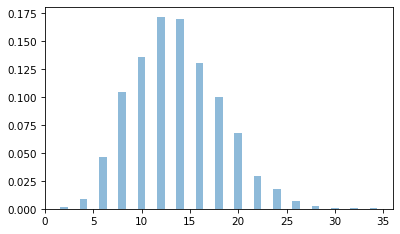

<IPython.core.display.Javascript object>

In [302]:
pmf_devs = Pmf.from_seq(simulated_devs)
pmf_devs.bar(alpha=0.5)

In [303]:
compute_p_value(simulated_devs, observed_dev)

0.12887112887112886

<IPython.core.display.Javascript object>

## Chi-squared tests

In the previous section we used total deviation as the test statistic.
But for testing proportions it is more common to use the chi-squared statistic: $$\chi^2 = \sum_i \frac{(O_i - E_i)^2}{E_i}$$ Where $O_i$ are the observed frequencies and $E_i$ are the expected frequencies.
Here's the Python code:

In [33]:
class DiceChiTest(DiceTest):

    def test_statistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected) ** 2 / expected)
        return test_stat

<IPython.core.display.Javascript object>

Squaring the deviations (rather than taking absolute values) gives more weight to large deviations.
Dividing through by `expected` standardizes the deviations, although in this case it has no effect because the expected frequencies are all equal.

In [34]:
dct = DiceChiTest(data)
dct.p_value()

0.039

<IPython.core.display.Javascript object>

The p-value using the chi-squared statistic is 0.037, substantially smaller than what we got using total deviation, 0.13. If we take the 5% threshold seriously, we would consider this effect statistically significant.
But considering the two tests together, I would say that the results are borderline.
I would not rule out the possibility that the die is crooked, but I would not convict the accused cheater.

This example demonstrates an important point: the p-value depends on the choice of test statistic and the model of the null hypothesis, and sometimes these choices determine whether an effect is statistically significant or not.

The p-value for this data is 0.13, which means that if the die is fair we expect to see the observed total deviation, or more, about 13% of the time.
So the apparent effect is not statistically significant.

## Errors

In classical hypothesis testing, an effect is considered statistically significant if the p-value is below some threshold, commonly 5%. This procedure raises two questions:

-   If the effect is actually due to chance, what is the probability that we will wrongly consider it significant? This probability is the **false positive rate**.

-   If the effect is real, what is the chance that the hypothesis test will fail? This probability is the **false negative rate**.

The false positive rate is relatively easy to compute: if the threshold is 5%, the false positive rate is 5%. Here's why:

-   If there is no real effect, the null hypothesis is true, so we can compute the distribution of the test statistic by simulating the null hypothesis.
Call this distribution $CDF_T$.

-   Each time we run an experiment, we get a test statistic, $t$, which is drawn from $CDF_T$.
Then we compute a p-value, which is the probability that a random value from $CDF_T$ exceeds `t`, so that's $1 - CDF_T(t)$.

-   The p-value is less than 5% if $CDF_T(t)$ is greater than 95%; that is, if $t$ exceeds the 95th percentile.
And how often does a value chosen from $CDF_T$ exceed the 95th percentile? 5% of the time.

So if you perform one hypothesis test with a 5% threshold, you expect a false positive 1 time in 20.

## Power

The false negative rate is harder to compute because it depends on the actual effect size, and normally we don't know that.
One option is to compute a rate conditioned on a hypothetical effect size.

For example, if we assume that the observed difference between groups is accurate, we can use the observed samples as a model of the population and run hypothesis tests with simulated data:

In [41]:
def false_neg_rate(data, num_runs=100):
    group1, group2 = data
    count = 0
    for i in range(num_runs):
        sample1 = resample(group1)
        sample2 = resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.p_value(iters=101)
        if p_value > 0.05:
            count += 1
    return count / num_runs

<IPython.core.display.Javascript object>

`FalseNegRate` takes data in the form of two sequences, one for each group.
Each time through the loop, it simulates an experiment by drawing a random sample from each group and running a hypothesis test.
Then it checks the result and counts the number of false negatives.

`Resample` takes a sequence and draws a sample with the same length, with replacement:

In [42]:
def resample(xs):
    return np.random.choice(xs, len(xs), replace=True)

<IPython.core.display.Javascript object>

Here's the code that tests pregnancy lengths:

In [43]:
live, firsts, others = nsfg.make_frames()
data = firsts.prglngth.values, others.prglngth.values
neg_rate = false_neg_rate(data)
neg_rate

0.76

<IPython.core.display.Javascript object>

The result is about 70%, which means that if the actual difference in mean pregnancy length is 0.078 weeks, we expect an experiment with this sample size to yield a negative test 70% of the time.

This result is often presented the other way around: if the actual difference is 0.078 weeks, we should expect a positive test only 30% of the time.
This "correct positive rate" is called the **power** of the test, or sometimes "sensitivity".
It reflects the ability of the test to detect an effect of a given size.

In this example, the test had only a 30% chance of yielding a positive result (again, assuming that the difference is 0.078 weeks).
As a rule of thumb, a power of 80% is considered acceptable, so we would say that this test was "underpowered."

In general, a negative hypothesis test does not imply that there is no difference between the groups; instead, it suggests that if there is a difference, it is too small to detect with this sample size.

## Replication

The hypothesis testing process I demonstrated in this chapter is not, strictly speaking, good practice.

First, I performed multiple tests.
If you run one hypothesis test, the chance of a false positive is about 1 in 20, which might be acceptable.
But if you run 20 tests, you should expect at least one false positive, most of the time.

Second, I used the same dataset for exploration and testing.
If you explore a large dataset, find a surprising effect, and then test whether it is significant, you have a good chance of generating a false positive.

To compensate for multiple tests, you can adjust the p-value threshold (see <https://en.wikipedia.org/wiki/Holm-Bonferroni_method>).
Or you can address both problems by partitioning the data, using one set for exploration and the other for testing.

In some fields these practices are required or at least encouraged.
But it is also common to address these problems implicitly by replicating published results.
Typically the first paper to report a new result is considered exploratory.
Subsequent papers that replicate the result with new data are considered confirmatory.

As it happens, we have an opportunity to replicate the results in this chapter.
The first edition of this book is based on Cycle 6 of the NSFG, which was released in 2002.
In October 2011, the CDC released additional data based on interviews conducted from 2006--2010.
`nsfg.py` contains code to read and clean this data.
In the new dataset:

-   The difference in mean pregnancy length is 0.16 weeks and statistically significant with $p < 0.001$ (compared to 0.078 weeks in the original dataset).

-   The difference in birth weight is 0.17 pounds with $p < 0.001$ (compared to 0.12 lbs in the original dataset).

-   The correlation between birth weight and mother's age is 0.08 with $p < 0.001$ (compared to 0.07).

-   The chi-squared test is statistically significant with $p < 0.001$ (as it was in the original).

In summary, all of the effects that were statistically significant in the original dataset were replicated in the new dataset, and the difference in pregnancy length, which was not significant in the original, is bigger in the new dataset and significant.

## Glossary

-   **hypothesis testing**: The process of determining whether an apparent effect is statistically significant.

-   **test statistic**: A statistic used to quantify an effect size.

-   **null hypothesis**: A model of a system based on the assumption that an apparent effect is due to chance.

-   **p-value**: The probability that an effect could occur by chance.

-   **statistically significant**: An effect is statistically significant if it is unlikely to occur by chance.

-   **permutation test**: A way to compute p-values by generating permutations of an observed dataset.

-   **resampling test**: A way to compute p-values by generating samples, with replacement, from an observed dataset.

-   **two-sided test**: A test that asks, "What is the chance of an effect as big as the observed effect, positive or negative?"

-   **one-sided test**: A test that asks, "What is the chance of an effect as big as the observed effect, and with the same sign?"

-   **chi-squared test**: A test that uses the chi-squared statistic as the test statistic.

-   **false positive**: The conclusion that an effect is real when it is not.

-   **false negative**: The conclusion that an effect is due to chance when it is not.

-   **power**: The probability of a positive test if the null hypothesis is false.

## Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely detect an effect if there is one.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data.

To choose a random subset of the data, you can use the `DataFrame` method `sample` like this:

In [44]:
n = 100
sample = live.sample(n)

<IPython.core.display.Javascript object>

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

<IPython.core.display.Javascript object>

9148	0.16	0.00	0.00	0.00
4574	0.59	0.00	0.00	0.00
2287	0.85	0.00	0.01	0.00
1143	0.86	0.12	0.02	0.06
571	0.94	0.01	0.21	0.00
285	0.54	0.57	0.11	0.03
142	0.37	0.95	0.70	0.92


<IPython.core.display.Javascript object>

**Exercise:** In Section 9.3, we simulated the null hypothesis by permutation; that is, we treated the observed values as if they represented the entire population, and randomly assigned the members of the population to the two groups.

An alternative is to use the sample to estimate the distribution for the population, then draw a random sample from that distribution.
This process is called resampling.
There are several ways to implement resampling, but one of the simplest is to draw a sample with replacement from the observed values, as in Section 9.10.

Write a class named `DiffMeansResample` that inherits from `DiffMeansPermute` and overrides `run_model` to implement resampling, rather than permutation.

Use this model to test the differences in pregnancy length and birth weight.
How much does the model affect the results?

<IPython.core.display.Javascript object>


diff means resample preglength
p-value = 0.1684
actual = 0.07803726677754952
ts max = 0.22218926465460953


<IPython.core.display.Javascript object>


diff means resample birthweight
p-value = 0.0
actual = 0.12476118453549034
ts max = 0.11484721423835076


<IPython.core.display.Javascript object>

## First babies again

Earlier in this chapter we looked at pregnancy lengths for first babies and others, and concluded that the apparent differences in mean and standard deviation are not statistically significant.
But in Section [\[visualization\]](#visualization){reference-type="ref" reference="visualization"}, we saw several apparent differences in the distribution of pregnancy length, especially in the range from 35 to 43 weeks.
To see whether those differences are statistically significant, we can use a test based on a chi-squared statistic.

The code combines elements from previous examples:

In [38]:
from empiricaldist import Pmf


class PregLengthTest(HypothesisTest):

    def make_model(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))
        pmf = Pmf.from_seq(self.pool)
        self.values = range(35, 44)
        self.expected_probs = pmf(self.values)

    def run_model(self):
        np.random.shuffle(self.pool)
        data = self.pool[: self.n], self.pool[self.n :]
        return data

    def test_statistic(self, data):
        firsts, others = data
        stat = self.chi_squared(firsts) + self.chi_squared(others)
        return stat

    def chi_squared(self, lengths):
        hist = Hist(lengths)
        observed = np.array(hist.freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected) ** 2 / expected)
        return stat

<IPython.core.display.Javascript object>

The data are represented as two lists of pregnancy lengths.
The null hypothesis is that both samples are drawn from the same distribution.
`make_model` models that distribution by pooling the two samples using `hstack`.
Then `run_model` generates simulated data by shuffling the pooled sample and splitting it into two parts.

`make_model` also defines `values`, which is the range of weeks we'll use, and `expected_probs`, which is the probability of each value in the pooled distribution.

Here's the code that computes the test statistic:

In [39]:
data = firsts.prglngth.values, others.prglngth.values

<IPython.core.display.Javascript object>

In [40]:
ht = PregLengthTest(data)
p_value = ht.p_value()
print("p-value =", p_value)
print("actual =", ht.actual)
print("ts max =", np.max(ht.test_stats))

p-value = 0.0
actual = 101.50141482893264
ts max = 24.34461000174318


<IPython.core.display.Javascript object>

`TestStatistic` computes the chi-squared statistic for first babies and others, and adds them.

`ChiSquared` takes a sequence of pregnancy lengths, computes its histogram, and computes `observed`, which is a list of frequencies corresponding to `self.values`.
To compute the list of expected frequencies, it multiplies the pre-computed probabilities, `expected_probs`, by the sample size.
It returns the chi-squared statistic, `stat`.

For the NSFG data the total chi-squared statistic is 102, which doesn't mean much by itself.
But after 1000 iterations, the largest test statistic generated under the null hypothesis is 32. We conclude that the observed chi-squared statistic is unlikely under the null hypothesis, so the apparent effect is statistically significant.

This example demonstrates a limitation of chi-squared tests: they indicate that there is a difference between the two groups, but they don't say anything specific about what the difference is.